<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Деление-фрейма-на-выборки" data-toc-modified-id="Деление-фрейма-на-выборки-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Деление фрейма на выборки</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Модель-LogisticRegression()" data-toc-modified-id="Модель-LogisticRegression()-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Модель LogisticRegression()</a></span></li><li><span><a href="#Модель-DecisionTreeClassifier" data-toc-modified-id="Модель-DecisionTreeClassifier-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Модель DecisionTreeClassifier</a></span></li><li><span><a href="#Модель-RandomForestClassifier()" data-toc-modified-id="Модель-RandomForestClassifier()-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Модель RandomForestClassifier()</a></span></li><li><span><a href="#Полученные-результаты" data-toc-modified-id="Полученные-результаты-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Полученные результаты</a></span></li></ul></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [24]:
!pip install imblearn

In [25]:
import numpy as np
import pandas as pd
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('wordnet','punkt')
nltk.download('averaged_perceptron_tagger')

from tqdm import tqdm
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

from catboost import CatBoostClassifier

[nltk_data] Downloading package wordnet to punkt...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [26]:
# Выведем датафрейм и изучим признаки
try:
    df = pd.read_csv('D://Data Science//Проекты//Проект Викишоп//toxic_comments.csv')
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')

# Выведем датафрейм 
display(df)
display(df.describe())
df.info()

# Выведем размер таблиб
df.shape

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


(159292, 3)

In [27]:
# Проверим датафрейм на наличие пропусков и дубликатов
print('\nКоличество дубликатов в датафрейме:', df.duplicated().sum())
print('\nКоличество пропущенных значений:\n', df.isna().sum())


Количество дубликатов в датафрейме: 0

Количество пропущенных значений:
 Unnamed: 0    0
text          0
toxic         0
dtype: int64


Дубликатов и пропусков нет, избавимся от столбца Unnamed, так как он дублирует индексы

In [28]:
# Удалим столбец Unnamed:0 так как он не несет особой ценности
df = df.drop(['Unnamed: 0'], axis=1)

In [29]:
# Создадим корпус с коментариями
# corpus = list(df['text'])

In [30]:
#corpus = df['text'].values.astype('U')
#print(corpus[0])

Избавимся от лишних символов и лемматизируем текст:

In [31]:
# Создадим класс для лемматизации
def lemmatize(text):
    lemma = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    lemmatized_out = ' '.join([lemma.lemmatize(word) for word in word_list])
    clear = re.sub('[^a-zA-Z]', ' ', lemmatized_out)
    clear = ' '.join(clear.split())
    clear = clear.lower()
    return clear

In [32]:
%%time 
tqdm.pandas()
df['text'] = df['text'].apply(lemmatize) 
df.head()

CPU times: user 2min 27s, sys: 525 ms, total: 2min 28s
Wall time: 2min 30s


,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not trying to edit war it s...,0
3,more i ca n t make any real suggestion on impr...,0
4,you sir are my hero any chance you remember wh...,0


Посмотрим долю распределения токсичных и не токсичных коментариев

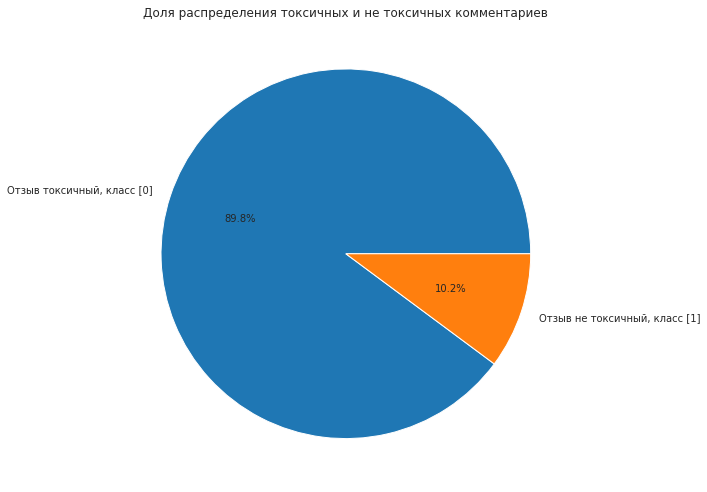

In [33]:
sns.set_style('darkgrid')
df['toxic'].value_counts(normalize=True).plot(kind='pie',figsize=[8.5,8.5], 
                                              autopct='%1.1f%%',
                                              labels=['Отзыв токсичный, класс [0]',
                                                      'Отзыв не токсичный, класс [1]'])
plt.title('Доля распределения токсичных и не токсичных комментариев')
plt.ylabel('')
plt.show()

**Вывод:** Данные обработанны, коментарии очищены и лемматизированы. Доля токсичных коменнтариев составляет 89,8 %. Разделим датафрейм по целевому признаку lemm_text на выборки и уменьшим количество 0, чтобы избежать дисбаланса классов. 

## Обучение

### Деление фрейма на выборки 

In [34]:
# Разделим датафрейм на целевые значения и признаки
features = df['text']
target = df['toxic']

In [35]:
# Поделим дааные на тренировачную, валидационную и тестевую выборки
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=.2, 
                                                                            random_state=15, 
                                                                            stratify=target)

# features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=.5, random_state=12345)

for i in [features_train, target_train, features_test, target_test]:
    print(i.shape)

(127433,)
(127433,)
(31859,)
(31859,)


In [36]:
# Сделаем стоп слова и векторизуем текст
#nltk.download('stopwords')
#stopwords = set(nltk_stopwords.words('english'))
#count_tf_idf = TfidfVectorizer(stop_words=stopwords)
#features_train = count_tf_idf.fit_transform(features_train)
#features_test = count_tf_idf.transform(features_test)

In [37]:
# Уменьшим количество 0 в тренеровачной выборке
df_train = df.iloc[target_train.index]

# Создадим столбец с нулевыми значениями
target_tr_0 = df_train[df_train['toxic']==0]['toxic']
# Создадим столбец с нулевыми значениями
target_tr_1 = df_train[df_train['toxic']==1]['toxic']

# Создадим столбец и приравняем количество едениц и нулей
target_tr0_resample = target_tr_0.sample(target_tr_1.shape[0], random_state=12345)
target_tr_resample = pd.concat([target_tr0_resample, target_tr_1])

# Создадим датафрейм и применим новые признаки
features_tr_resample = df.iloc[target_tr_resample.index]

# Создадим тренировачные и тестевые выборки сбалансированными классами
features_tr_res, target_tr_res = shuffle(features_tr_resample, target_tr_resample, random_state = 15)

features_tr_res = features_tr_res['text']

# Проверим соотношение нулей и едениц в тренировачной выборке
print(target_tr_res.value_counts())



0    12949
1    12949
Name: toxic, dtype: int64


In [38]:
# Сделаем стоп слова и векторизуем ресемплированную тренировачную выборку
#nltk.download('stopwords')
#stopwords = set(nltk_stopwords.words('english'))
#count_tf_idf = TfidfVectorizer(stop_words=stopwords)
#features_tr_res = count_tf_idf.fit_transform(features_tr_res)

**Вывод:** Данные поделены, сбалансированы и ресемплированы

### Обучение моделей

In [39]:
#tscv = TimeSeriesSplit(n_splits=3)

#### Модель LogisticRegression()

In [40]:
# %%time
# pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', 
#                                                sublinear_tf=True)),
#                      ('lr', LogisticRegression(random_state=15))])
# # Найдем лучшие гиперпараметры модели
# param_lr = {'tfidf__max_df': (.25, .5, .75),
#             'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
#             'lr__C':[1, 1, 10]}
# # Применим гридсеч
# lr_grid = GridSearchCV(pipeline,
#                        param_lr, 
#                        scoring='f1', 
#                        cv=3)
# # Обучаем на тренировачных ресемплированных выборках
# lr_grid.fit(features_train, target_train)

# lr_best_params = lr_grid.best_params_

# best_score_lr = lr_grid.best_score_

# print('Лучшие гиперпараметры:', lr_best_params)            
# print('F1 на тренировачной выборке:', round(max(mts_lr), 3))

In [59]:
%%time


pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', 
                                               sublinear_tf=True)),
                     ('lr', LogisticRegression(random_state=15))])
# Найдем лучшие гиперпараметры модели
param_lr = {'tfidf__max_df': (.25, .5, .75),
            'tfidf__ngram_range': [(1, 1), (1, 2)],
            'lr__C':[1, 5, 10]}
# Применим гридсеч
lr_grid = HalvingRandomSearchCV(pipeline,
                       param_lr, 
                       scoring='f1', 
                       cv=3, n_jobs=-1)
# Обучаем на тренировачных ресемплированных выборках
lr_grid.fit(features_train, target_train)

lr_best_params = lr_grid.best_params_

best_score_lr = lr_grid.best_score_

best_score_lr = round(best_score_lr, 3)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 18 is smaller than n_iter=10619. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and bei

CPU times: user 49.5 s, sys: 0 ns, total: 49.5 s
Wall time: 49.8 s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [60]:
# f1 на тренировачной выборке
print('Лучшие гиперпараметры:', lr_best_params)            
print('F1 на тренировачной выборке:', round(best_score_lr, 3))

Лучшие гиперпараметры: {'tfidf__ngram_range': (1, 1), 'tfidf__max_df': 0.75, 'lr__C': 10}
F1 на тренировачной выборке: 0.0


#### Модель DecisionTreeClassifier

In [62]:
%%time
pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                     ('dtc', DecisionTreeClassifier())])
# Найдем лучшие гиперпараметры модели
param_dtr = {'dtc__max_depth': ([x for x in range(1, 25)]),
             'dtc__random_state': ([15]), 
             'dtc__class_weight': (['balanced'])}
# Применим гридсеч
dtr_grid = HalvingRandomSearchCV(pipeline, 
                               param_dtr, 
                               scoring='f1',
                               cv=3, n_jobs=-1)

# Обучаем на тренировачных ресемплированных выборках
dtr_grid.fit(features_train, target_train)
dtr_best_params = dtr_grid.best_params_

best_score_dtr = dtr_grid.best_score_

best_score_dtr = round(max(best_score_dtr),3)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 24 is smaller than n_iter=10619. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and bei

TypeError: 'numpy.float64' object is not iterable

In [63]:
# f1 на тренировачной выборке
print('Лучшие гиперпараметры:', dtr_best_params)
print('F1 на тренировачной выборке:', best_score_dtr) 

Лучшие гиперпараметры: {'dtc__random_state': 15, 'dtc__max_depth': 2, 'dtc__class_weight': 'balanced'}
F1 на тренировачной выборке: 0.2814814814814815


#### Модель RandomForestClassifier()

In [64]:
%%time
pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')), 
                     ('rfc', RandomForestClassifier())])
# Найдем лучшие гиперпараметры модели
param_rfc = {'rfc__n_estimators': range(30, 50, 10),
             'rfc__max_depth': range(5, 10, 2),
             'rfc__min_samples_leaf': range(3,5),
             'rfc__min_samples_split': range(2,6,2),
             'rfc__verbose' : [0], 
             'rfc__class_weight':['balanced']}

# Применим гридсеч
rfc_grid = HalvingRandomSearchCV(pipeline,
                               param_rfc,
                               scoring='f1',
                               cv=3)

# Обучаем на тренировачных ресемплированных выборках
rfc_grid.fit(features_train, target_train)

best_score_rfc = rfc_grid.best_score_

best_score_rfc = round(max(best_score_rfc),3)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 24 is smaller than n_iter=10619. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and bei

TypeError: 'numpy.float64' object is not iterable

In [65]:
# f1 на тренировачной выборке
print('Лучшие гиперпараметры:', rfc_best_params)
print('F1 на тренировачной выборке:', best_score_rfc) 
print()

Лучшие гиперпараметры: {'rfc__class_weight': 'balanced', 'rfc__max_depth': 9, 'rfc__min_samples_leaf': 4, 'rfc__min_samples_split': 4, 'rfc__n_estimators': 40, 'rfc__verbose': 0}
F1 на тренировачной выборке: 0.10256410256410257



#### Полученные результаты

In [67]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'DecisionTreeClassifier']
data = {'F1 на тренировачной модели': [best_score_lr,
                                       best_score_rfc,
                                       best_score_dtr]}


f1_models = pd.DataFrame(data=data, index=index)
f1_models['Выполнение задачи'] = f1_models['F1 на тренировачной модели'] > 0.75
f1_models

,F1 на тренировачной модели,Выполнение задачи
LinearRegression,0.000000,False
RandomForestRegressor,0.102564,False
DecisionTreeClassifier,0.281481,False


In [68]:
%%time
# Проверим логистическую регрессию на тестевой выборке
predictions_lr = lr_grid.predict(features_test)
lr_test_f1 = round(f1_score(target_test, predictions_lr), 3) 
print('F1 на тестовой выборке:', lr_test_f1)  

F1 на тестовой выборке: 0.783
CPU times: user 1.5 s, sys: 0 ns, total: 1.5 s
Wall time: 1.57 s


## Выводы

**Вывод:** На этапе предообработки был удален столбец Unnamed, так как он дублировал признаки. Текст был очищен от лишних символов и лемматизирован. По анализу распределения токсичных комментариев выявлен дисбаланс, доля не токсичных комментариев составляет 10,2 %. После деления фрейма на выборке, бала произведена векторизация текста и сбалансирование классов. В ходе обучения и тестирования лучшей моделью оказалась Линейная регрессия со значением метрики качества F1 в 0.76.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны